## Shapley Residual 公式推導

考慮有$d$個特徵的情形, $[d]\overset{\Delta}{=}\{1,2,3,...,d\}$, a coalition of features $S \in N \overset{\Delta}{=}2^{[d]}$.

原 value function $v$ 有對應的 differential operator: $\nabla v$. 
$$ \nabla: R^V \rightarrow R^E, \nabla v(S,S\cup \{i\})=v(S \cup \{i\})-v(S)$$


針對特徵$i$ 有 partial gradient: $\nabla_i v$.
$$
\nabla_i v(S, S \cup \{j\}) =  \begin{cases}
v(S \cup j) - v(S),  & i = j \\
0, & \text{otherwise}
\end{cases}
$$

計算 Shapley Residuals 需要先找出 $v_i$ 最接近 partial gradient $\nabla_i v$.

Solve $v_i = argmin_{X \in R^V} || \nabla X - \nabla_i v ||_2^2$

value function $X = \{x_0(=0), x_1, …, x_{n-1}\}$, where $n=2^d$.  $x_i$ represents both the value of the vertex and its associated fearture subset.

$$
\nabla X =
\begin{cases}
x_i - x_j,  & \text{if $x_i$ is adjunct to $x_j$ and comprises one more feature than $x_j$}  \\
0, & \text{otherwise}
\end{cases}
$$

將 $\nabla X$ 以矩陣形式（$A*X$）來表示，則$A$的維度應為 $m * n$, where $m=d*2^{d-1}$ (edges).

每一列(row) $A^k$ 代表一個 edge $e^k$ from $x_j$ to $x_i$

$$
A^k = 
\begin{cases}
a^k_i = 1,  a^k_j = -1,  & \text{if $x_i$ is adjunct to $x_j$ and comprises one more feature than $x_j$} \\
0, & \text{otherwise}
\end{cases}
$$

### ----- 解方程組 ---- 
若定義 $l = || A*X-Y ||^2_2$ , 求 $X$ 為何值時 $l$ 可取得最小值，其中 $A$ 為 $m*n$ 矩陣，$X$ 為 $n*1$ 向量， $Y$ 為 $m*1$ 向量。

由於我們定義 $x_0=0$, 故附加一列（row）$A^i=[1,0,...,0]$ 在$A$最後來求解，所以 $A$ 變為 $(m+1)*n$, $Y$ 變為 $(m+1)*1$ 向量 $[\nabla_i v, 0]$.

經全微分計算可得出 $X=((A^TA)^{-1}A^T)Y$， 我們可以先計算 $W=(A^T A)^{-1} A^T$，再代入 $W*Y$即可得到 $X$

本題中 $m$ 為 edge 數量, $n$ 為端點數。

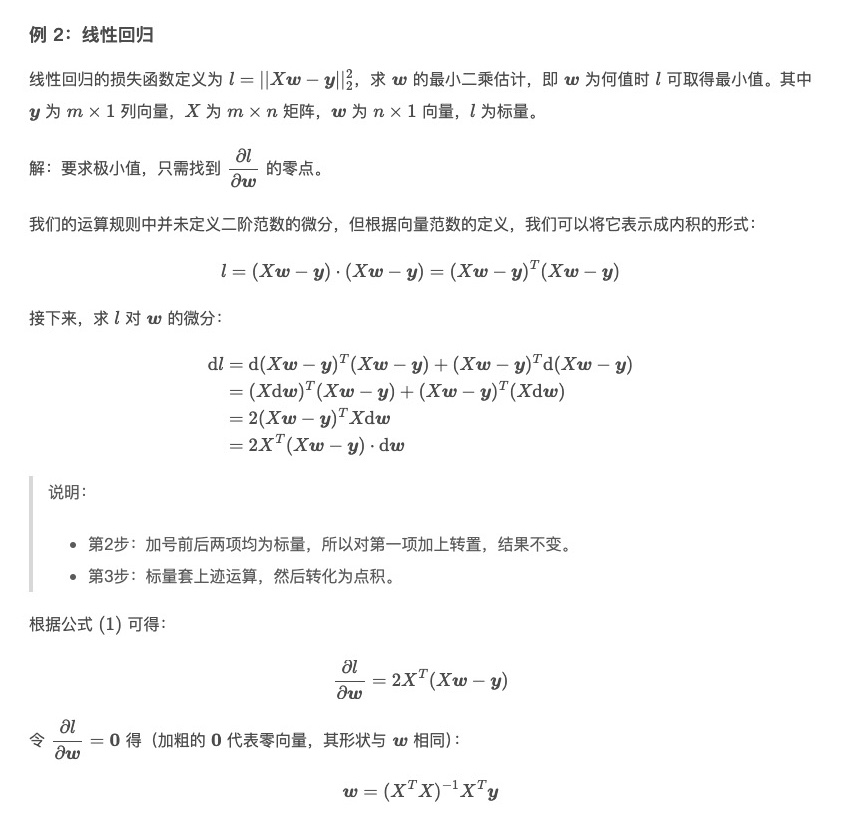

In [37]:
import numpy as np
import itertools
import bisect
from itertools import combinations

np.set_printoptions(precision=3, suppress=True)

class SubsetDict(dict):
    def __getitem__(self, key):
        return super().__getitem__(tuple(key))
    def __setitem__(self, key, value):
        super().__setitem__(tuple(key), value)
    def __str__(self):
        # Define custom formatting for printing
        return "\n".join("{}: {:.4f}".format(key, value) for key, value in self.items())


def generate_all_subsets(num):
    num_set = [i for i in range(num)]
    all_subsets = [np.array(s) for r in range(num+1) for s in combinations(num_set, r) ]
    # Create a hash table to store the index of each subset
    subset_index_table = SubsetDict()
    for index, value in enumerate(all_subsets):
        subset_index_table[value] = index
    return all_subsets, subset_index_table, len(all_subsets)

class Hypercube:
    '''
    A class to create a hypercube object which stores values of vertices
    '''    
    #輸入維度
    def __init__(self, n_dim):   
        self.n_dim = n_dim
        self.vertex_values = SubsetDict()
        self.vertices, self.vertex_index, self.vertex_num = generate_all_subsets(n_dim)  #所有子集包含空集，即所有點
        self.edges, self.edge_num = self.build_edges()
        self.differential_matrix = None
        self.weight_matrix = None
        self.generate_min_l2_norm_matrix()
    
    def build_edges(self):
        full_elements = [i for i in range(self.n_dim)]
        full_set = set(full_elements)
        edges = []
        for r in range(self.n_dim):
            for v in combinations(full_elements, r):
                v_set = set(v)
                adjunct_v = full_set - v_set
                for new_elem in adjunct_v:
                    d_set = v_set | {new_elem}
                    edges.append((np.array(list(v_set)),np.array(list(d_set))))
        return edges, len(edges)

    def set_vertex_values(self, vertex_values):         #設置點值
        for v in vertex_values:                         #用鍵值來做查找
            self.vertex_values[v] = vertex_values[v]
        
    def does_edge_exist(self, v1, v2):
        if abs(len(v1)-len(v2))==1:
            interset = np.intersect1d(v1,v2)
            smaller = v1 if len(v1)<len(v2) else v2
            return True if np.array_equal(smaller, interset) else False
        else:
            return False
    
    # Establish the matrix A in the above formula: AX-Y
    def generate_differential_matrix(self):
        if self.differential_matrix is None:
            self.differential_matrix = np.zeros((self.edge_num+1, self.vertex_num))
            for i,v_pair in enumerate(self.edges):
                j = self.vertex_index[v_pair[1]]
                k = self.vertex_index[v_pair[0]]
                self.differential_matrix[i][j] = 1
                self.differential_matrix[i][k] = -1
            # Add one more equestion that x_0 = 0 into the matrix form
            self.differential_matrix[-1][0]=1
        return self.differential_matrix

    # Pre-calcuate "W=(A^T*A)^-1*A^T" for the formula "X = ((A^T*A)^-1*A^T)*Y
    def generate_min_l2_norm_matrix(self):
        matrix_A = self.generate_differential_matrix()
        matrix_A_T = np.transpose(matrix_A)
        self.weight_matrix = np.linalg.inv(matrix_A_T @ matrix_A) @ matrix_A_T

    def get_gradient_vector(self):
        gradient_vector = np.zeros(self.edge_num)
        for i,v_pair in enumerate(self.edges):
            gradient_vector[i] = self.vertex_values[v_pair[1]]-self.vertex_values[v_pair[0]]    
        return gradient_vector
        
    def get_partial_gradient_vector(self,feature_i):
        partial_gradient_vector = np.zeros(self.edge_num)
        for i,v_pair in enumerate(self.edges):
            if (not feature_i in v_pair[0]) and (feature_i in v_pair[1]):
                partial_gradient_vector[i] = self.vertex_values[v_pair[1]]-self.vertex_values[v_pair[0]]    
        return partial_gradient_vector
    
    def resolve_vi(self, feature_i):
        pd = self.get_partial_gradient_vector(feature_i)
        # Append equation x_0=0 at the end of partial gradient vector.
        pd = np.append(pd, 0)
        vi = self.weight_matrix @ pd
        # Reconstruct the vertex values
        new_vertices = SubsetDict()
        for i,v in enumerate(self.vertices):
            new_vertices[v] = vi[i]
        return vi, new_vertices

In [43]:
feature_i = 0

hyper = Hypercube(3)
vertices = SubsetDict()
subsets, idx, _ = generate_all_subsets(3)

values = [0,1,0,0,1,1,2,3]
for v in subsets:
    vertices[v] = values.pop(0)
hyper.set_vertex_values(vertices)

pd = hyper.get_partial_gradient_vector(feature_i)
print(f'partial gradient of feature {feature_i}:', pd)
vi, new_vs = hyper.resolve_vi(feature_i)
print(f'argmin vi:',vi)
print(new_vs)

h1 = Hypercube(3)
h1.set_vertex_values(new_vs)
dvi = h1.get_gradient_vector()
print('gradient of vi:',dvi)
print('residual:',dvi-pd)


partial gradient of feature 0: [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
argmin vi: [0. 1. 0. 0. 1. 1. 0. 1.]
(): 0.0000
(0,): 1.0000
(1,): 0.0000
(2,): 0.0000
(0, 1): 1.0000
(0, 2): 1.0000
(1, 2): 0.0000
(0, 1, 2): 1.0000
gradient of vi: [ 1.  0.  0. -0. -0.  1.  0.  1. -0.  0.  0.  1.]
residual: [ 0.  0.  0. -0. -0.  0.  0.  0. -0.  0.  0.  0.]


友達資料處理

In [3]:
import os
import time
import pandas as pd
import numpy as np
import json
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from data_process import read_selected_data, get_y,  split_data, compute_class_weights
from dataset import BertDataset
from model import BertClassifier
from training import train_model
from utils import draw_pics, initial_record
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
import matplotlib.pyplot as plt
total_params = 14
csv_file_path = '/hcds_vol/private/luffy/GANGAN-master/data/processed_data/v014_stage_1.csv'
json_file_path = '/hcds_vol/private/luffy/GANGAN-master/data/controllable_para_v014_14.json'
tool_name = 'ASCVD'
epochs = 50000
lr = 1e-5
batch_size = 1024
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
save_folder_name = 'stage-1-param_'+str(total_params)+'-batch_'+str(batch_size)+'-lr_'+str(lr)
with open(json_file_path, 'r') as f:
    params = json.load(f)
    f.close()
s1_df = pd.read_csv(csv_file_path)
#s1_df.shape
all_key = list(params[tool_name]) 
params_list = []                #取得json檔內的特徵
for key in all_key:
    all_param = params[tool_name][key]
    if(type(all_param) == list):
        for param in all_param:
             params_list.append(param)
    else:
        params_list.append(all_param)
    
# 取得Json檔內包含的特徵
s1_df = s1_df[params_list] 
#print(params)
s1_df.head(10)
feature_df = s1_df.drop(['DFT_CNT'], axis=1)


/hcds_vol/private/luffy/anaconda3/envs/shap_res/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(feature_df)
nf_df = pd.DataFrame(X_standardized)
nf_df
param_group = [] # [2,2,4,2]
all_key = list(params[tool_name]) # ['EQ', 'PUMP', 'CH', 'VENT', 'y']
all_key.remove('y')

for key in all_key:
    all_value = params[tool_name][key]
    param_group.append(len(all_value))
param_group

[2, 2, 8, 2]

In [5]:
def padding_zero(df, tool_name, total_params, flag, params=params): 
    # 將一維參數matrix擴展為4維
    data_arr = df.to_numpy()
    result = []
    for i in range(len(data_arr)):
        arr_index = 0
        empty_arr = np.zeros((4,total_params)) # chamber數 * 總參數數量
        param_group_cp = param_group.copy()
        for j in range(len(empty_arr)):
            while(param_group_cp[j] > 0):
                empty_arr[j][arr_index] = data_arr[i][arr_index]
                param_group_cp[j] -= 1
                arr_index += 1
        
        if(flag == 1): # bert.py使用
            result.append(empty_arr)
        if(flag == 2): # bert_du.py使用
            result.append(empty_arr.tolist())
    
    if(flag == 1): # bert.py使用
        result = pd.DataFrame({'X': [result[i] for i in range(len(result))]})
    return result

In [6]:
nf_df_4d = padding_zero(nf_df,tool_name,total_params,flag=1)
nf_df_4d_object = nf_df_4d.to_numpy()
nf_df_4d_list = []
for i in range(len(nf_df_4d_object)):
    nf_df_4d_list.append(nf_df_4d_object[i][0])
nf_df_4d_arr = np.array(nf_df_4d_list)

友達資料模型預測及平均

In [7]:
from torch.utils.data import DataLoader, TensorDataset
s1_model_path = '/hcds_vol/private/luffy/GANGAN-master/model/predictor/stage_1_checkpoint.pth'
s1_model =  torch.load(s1_model_path).to(device)
s1_model.eval()
nf_df_4d_tensor = torch.tensor(nf_df_4d_arr,dtype=torch.float)
dataset = TensorDataset(nf_df_4d_tensor)
batch_size = 256
loader = DataLoader(dataset, batch_size=batch_size)
outputs = []
with torch.no_grad():
    for batch_data in loader:
        # 将数据移到指定的设备上（如 CUDA 设备）
        batch_data = batch_data[0].to(device)
        
        # 将数据传递给模型进行推理
        batch_output = s1_model(batch_data)
        probs = (torch.nn.functional.softmax(batch_output, dim=1))
        # 将输出保存起来
        outputs += probs

取得模型平均和對應output

In [8]:

output_arr = np.array([output.cpu().numpy()[0] for output in outputs])
output_df = pd.DataFrame({'Output': output_arr})
new_df = pd.concat([feature_df,output_df],axis=1)


In [25]:
def send_to_model(data,):
    scaler = StandardScaler()
    if 'Output' in data.columns:
        data = data.drop(columns=['Output'])
    data_standardized = scaler.fit_transform(data)
    data_standardized_df = pd.DataFrame(data_standardized)
    data_4d = padding_zero(data_standardized_df,tool_name,total_params,flag=1)
    data_4d_object =  data_4d.to_numpy()
    data_4d_list = []
    for i in range(len(data_4d_object)):
        data_4d_list.append(data_4d_object[i][0])
    data_4d_arr = np.array(data_4d_list)
    data_4d_tensor = torch.tensor(data_4d_arr,dtype=torch.float)
    my_dataset = TensorDataset(data_4d_tensor)
    batch_size = 256
    my_loader = DataLoader(my_dataset, batch_size=batch_size,num_workers=4)
    data_output = []
    with torch.no_grad():
        for batch_data in my_loader:
        # 将数据移到指定的设备上（如 CUDA 设备）
            batch_data = batch_data[0].to(device)
        
        # 将数据传递给模型进行推理
            batch_output = s1_model(batch_data)
            probs = (torch.nn.functional.softmax(batch_output, dim=1))
        # 将输出保存起来
            data_output += probs
    data_output_arr = np.array([output.cpu().numpy()[0] for output in data_output])
    data_expectation_out = data_output_arr.mean()
    return data_expectation_out

In [30]:
import numpy as np 
import warnings
import itertools
# 過濾掉FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
def all_subsets(n_elts):
    '''
        returns a list of 2^{n_elts} lists
        each a different subset of {1, 2,...,n_elts}
    '''
    res = [np.array(list(itertools.combinations(set(range(n_elts)), i))) for i in range(n_elts)]
    res = {i : res[i] for i in range(n_elts)}
    res[n_elts] = np.array([i for i in range(n_elts)]).reshape(1,-1)
    return [res[i][j] for i in range(1,n_elts+1) for j in range(res[i].shape[0])]
para_num = 14
AUO_coalitions = [np.array([])] + all_subsets(para_num) 
coalition_estimated_values = {}
instance = new_df.iloc[0]
#mean_exp = new_df['Output'].mean()
count_n = 1
selected_data = new_df.copy()
selected_data = selected_data[selected_data['PUMP_low']<20000 and selected_data['PUMP_high']>20000 and selected_data['VENT_low']<10000 and selected_data['VENT_high']>10000]
sample_df = selected_data.sample(n=1000,random_state=42)
mean_exp = sample_df['Output'].mean()
for coalition in AUO_coalitions:
    synth = sample_df.copy()                   #用copy()才不會去更改到原始的dataframe
    if len(coalition)!=0:
        #print(synth.iloc[:,coalition],instance[coalition])
        synth.iloc[:,coalition] = instance.iloc[coalition]
        if (2 in coalition and 3 not in coalition):
            PUMP_high = instance.iloc[2]
            synth = synth[synth.iloc[:,3]<PUMP_high]
            #print('good')
        elif (3 in coalition and 2 not in coalition):
            PUMP_low = instance.iloc[3]
            synth = synth[synth.iloc[:,2]>PUMP_low]
            #print('good')
        if (12 in coalition and 13 not in coalition):
            VENT_high = instance.iloc[12]
            synth = synth[synth.iloc[:,13]<VENT_high]
            #print('good')
        elif (13 in coalition and 12 not in coalition):
            VENT_low = instance.iloc[13]
            synth = synth[synth.iloc[:,12]>VENT_low]
            #print('good')
        #print(synth.head(10))
        #print('here')
        
    if count_n==100:
        #print('資料集長度:',len(synth))
        #print('feature數:',len(coalition))
        #print('資料: ',synth)
        #print(coalition)
        count_n = 0
        print('epoch')
    count_n += 1
    Exp = send_to_model(synth)
    impact = Exp - mean_exp
    coalition_estimated_values[str(coalition)] = impact


1000
1000
1000
989
1000
1000
1000
1000
1000
1000
1000
1000
1000
989
1000
1000
989
1000
1000
1000
1000
1000
1000
1000
1000


KeyboardInterrupt: 

In [33]:
AUOcube = Hypercube(para_num)


In [34]:
print(coalition_estimated_values)
AUOcube.set_vertex_values(coalition_estimated_values)

{'[]': 0.0034793615, '[0]': -0.03282529, '[1]': -0.0017248392, '[2]': -0.0072516203, '[3]': -0.0019363165, '[4]': 0.0056120753, '[5]': 0.02817136, '[6]': 0.020195127, '[7]': 0.0078001022, '[8]': -0.016284704, '[9]': -0.017367244, '[10]': -0.0045751333, '[11]': 0.003046453, '[12]': 0.0045694113, '[13]': 0.0072311163, '[0 1]': -0.055423737, '[0 2]': -0.04192108, '[0 3]': -0.0414086, '[0 4]': -0.0358088, '[0 5]': -0.0012938976, '[0 6]': -0.00867039, '[0 7]': -0.041057408, '[0 8]': -0.06446409, '[0 9]': -0.06805915, '[ 0 10]': -0.039872408}


In [35]:
for i  in range(para_num):
    AUOcube.trans_to_matrix(feature_i=i)
    res = AUOcube.shapley_residuals_in_matrix()
    print(new_df.columns[i],'residuals_of_feature',i,': ',res)

shapley_value:  -0.004930911155847021 residual sum:  3.3293670405579765
-0.004930911155847021
X_-TACT_TIME_mean residuals_of_feature 0 :  -675.203209980786
shapley_value:  -0.00034269805137924873 residual sum:  2.722957176002206
-0.005273609207226269
X_-CONVEYOR_SPEED_mean residuals_of_feature 1 :  -7945.64534301606
shapley_value:  -0.0006812795614584322 residual sum:  2.829704760558919
-0.005954888768684701
PUMP_high residuals_of_feature 2 :  -4153.514828041075
shapley_value:  -0.00026912490526833635 residual sum:  2.8614238981352487
-0.006224013673953038
PUMP_low residuals_of_feature 3 :  -10632.326633918214
shapley_value:  0.0003474167524239761 residual sum:  2.946310068743098
-0.005876596921529062
CLN1_over-etching-ratio residuals_of_feature 4 :  8480.621755244309


In [23]:
new_df.columns

Index(['X_-TACT_TIME_mean', 'X_-CONVEYOR_SPEED_mean', 'PUMP_high', 'PUMP_low',
       'CLN1_over-etching-ratio', 'CLN1_EPT_time', 'clean_count',
       'EPT_clean_count_ratio', 'NH3_TREAT_-RF_FREQ-max',
       'NH3_TREAT_-RF_FREQ-range', 'NH3_TREAT_-RF_FREQ-mean',
       'NP_3_-MFC_VOL_SIH4-range', 'VENT_high', 'VENT_low', 'Output'],
      dtype='object')

In [1]:
!nvidia-smi

Fri Mar 22 16:37:37 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  Off |
|  0%   45C    P8    19W / 480W |     17MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:07:00.0 Off |                  Off |
|  0%   